Code Lab 2: PatchCamelyon (PCAM) Histopathological Cancer Detection 
===

## The Problem
PCam an image classification dataset based off of one of the Camelyon16 tasks where 96x96, 3-color channel image patches are extracted from whole-slide images (WSI).  These slides were extracted from histopathologic scans of lymph node sections in order to determine if the lymph nodes contain metastases (cancer cells).  From the Camelyon16 web page:
>  This task has a high clinical relevance but requires large amounts of reading time from pathologists. Therefore, a successful solution would hold great promise to reduce the workload of the pathologists while at the same time reduce the subjectivity in diagnosis. [1](https://camelyon16.grand-challenge.org/)

![pcam-cover](https://github.com/basveeling/pcam/raw/master/pcam.jpg)

In this lab, we will explore transfer learning and explainable AI (XAI) techniques on the PCam dataset.

## Imports

We will start off using a similar setup to Code Lab 1.

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import pandas as pd
from IPython.display import display, HTML

In [3]:
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.13.1
Is GPU available: True
Is Eager Execution enabled?: False


## Dataset

### About Pcam

PCam is contained in three data splits:
    1. Training: 262K samples
    2. Validation: 33K
    3. Testing: 33K

The patches are labeled 'positive' for containing a metastases if there was at least one pixel of segment in the central 32x32 region of the patch from the segmentation of the WSI that the patch was extracted from.  The dataset was constructed to be evenly balanced with 50/50 'present'/'not present'.

### Load the dataset

In [4]:
import boto3
import os

s3 = boto3.client('s3',
endpoint_url = 'https://s3.wasabisys.com',
aws_access_key_id = 'VM2WCNG36U812Y1NGCT3',
aws_secret_access_key='g3Dqovv3IYlIFDZyNWONXZSU5yhGZvWhKOJrBQRI')

def download_files(filenames, save_dir):
    for i, filename in enumerate(filenames):
         print('Downloading %d: %s' % (i, filename)) 
         download_file(filename, save_dir)

def download_file(filename, save_dir):
    full_filename = os.path.join(save_dir,filename)
    if os.path.exists(full_filename):
        print('\tAlready have: %s' % full_filename)
        return
    s3.download_file('curaedlhw',filename,full_filename)
    print('\tCOMPLETE: %s saved to %s' % (filename, save_dir))

In [5]:
dataset_files = {
    'train' : {
        'x': 'camelyonpatch_level_2_split_train_x.h5.gz',
        'y': 'camelyonpatch_level_2_split_train_y.h5.gz',
        'meta': 'camelyonpatch_level_2_split_train_meta.csv'
    },
    'valid' : {
        'x': 'camelyonpatch_level_2_split_valid_x.h5.gz',
        'y': 'camelyonpatch_level_2_split_valid_y.h5.gz',
        'meta': 'camelyonpatch_level_2_split_valid_meta.csv'
    },
    'test' : {
        'x': 'camelyonpatch_level_2_split_test_x.h5.gz',
        'y': 'camelyonpatch_level_2_split_test_y.h5.gz',
        'meta': 'camelyonpatch_level_2_split_test_meta.csv'
    }
}
FILELIST = []
for scenario in dataset_files.values():
  for filename in scenario.values():
    FILELIST.append('data/' + filename)
print(FILELIST)

['data/camelyonpatch_level_2_split_train_x.h5.gz', 'data/camelyonpatch_level_2_split_train_y.h5.gz', 'data/camelyonpatch_level_2_split_train_meta.csv', 'data/camelyonpatch_level_2_split_valid_x.h5.gz', 'data/camelyonpatch_level_2_split_valid_y.h5.gz', 'data/camelyonpatch_level_2_split_valid_meta.csv', 'data/camelyonpatch_level_2_split_test_x.h5.gz', 'data/camelyonpatch_level_2_split_test_y.h5.gz', 'data/camelyonpatch_level_2_split_test_meta.csv']


In [6]:
IS_ONEPANEL = True
NEED_DOWNLOAD = False
if IS_ONEPANEL:
    DATA_DIR='/onepanel/input/datasets/curae/pcam-histo-cancer/1'
else:
    import os
    # import load_data
#     DATA_DIR = '/storage/codelab1'
    DATA_DIR = 'data'
    if NEED_DOWNLOAD:
        if not os.path.exists(DATA_DIR):
            os.mkdir(DATA_DIR)
        download_files(FILELIST,'')

The x and y files are compressed are so we need to extract them to local.

In [7]:
import gzip
import shutil
import glob
GZIPLIST = glob.glob(DATA_DIR+'/*.gz')
for filename in GZIPLIST:
  with gzip.open(filename, 'rb') as f_in:
      filename2 = '.'.join(filename.split('.')[:-1])
      with open(filename2, 'wb') as f_out:
          print('Extracing %s' % filename2)
          shutil.copyfileobj(f_in, f_out)
GZIPLIST

Extracing /onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_train_mask.h5
Extracing /onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_valid_x.h5
Extracing /onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_test_x.h5
Extracing /onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_train_y.h5
Extracing /onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_valid_y.h5
Extracing /onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_train_x.h5
Extracing /onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_test_y.h5


['/onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_train_mask.h5.gz',
 '/onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_valid_x.h5.gz',
 '/onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_test_x.h5.gz',
 '/onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_train_y.h5.gz',
 '/onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_valid_y.h5.gz',
 '/onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_train_x.h5.gz',
 '/onepanel/input/datasets/curae/pcam-histo-cancer/1/camelyonpatch_level_2_split_test_y.h5.gz']

Now lets load the datasets into memory.

In [8]:
from tensorflow.keras.utils import HDF5Matrix

datasets = {
    'train' : {},
    'valid' : {},
    'test' : {}
}

datasets['train']['x'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['train']['x'].split('.')[:-1]),'x',end=100000)
datasets['train']['y'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['train']['y'].split('.')[:-1]),'y',end=100000)
datasets['train']['meta'] = pd.read_csv(DATA_DIR+'/'+dataset_files['train']['meta'],index_col=0)

datasets['valid']['x'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['valid']['x'].split('.')[:-1]),'x')
datasets['valid']['y'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['valid']['y'].split('.')[:-1]),'y')
datasets['valid']['meta'] = pd.read_csv(DATA_DIR+'/'+dataset_files['valid']['meta'],index_col=0)

datasets['test']['x'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['test']['x'].split('.')[:-1]),'x')
datasets['test']['y'] = HDF5Matrix(DATA_DIR+'/'+'.'.join(dataset_files['test']['y'].split('.')[:-1]),'y')
datasets['test']['meta'] = pd.read_csv(DATA_DIR+'/'+dataset_files['test']['meta'],index_col=0)

Need to squeeze extra dimensions off of labels.

In [9]:
for scenario in datasets.keys():
  datasets[scenario]['y'] = np.array(datasets[scenario]['y']).reshape(-1) 

### Inspect Dataset

In [10]:
datasets['train']['meta'].head()

,coord_y,coord_x,tumor_patch,center_tumor_patch,wsi
0,63104,43648,False,False,camelyon16_train_tumor_104
1,148544,74048,True,True,camelyon16_train_tumor_003
2,64192,78912,True,True,camelyon16_train_tumor_089
3,98048,72128,True,True,camelyon16_train_tumor_004
4,27264,50688,False,False,camelyon16_train_normal_118


In [11]:
print("Shape of train_y: " + str(datasets['train']['y'].shape))

Shape of train_y: (100000,)


In [12]:
sample_img, sample_y = datasets['train']['x'][:10], datasets['train']['y'][:10]

In [13]:
sample_img.shape, sample_y.shape

((10, 96, 96, 3), (10,))

Below we can see that there are a few differences at a high level between those with metastases and those without.  Principally, those with cancerous cells tend to have larger, balloon-like cells with irregular shapes.  These cells also tend to absorb less stain.  Complicating these trends however is that not all patches are completely full of cells.

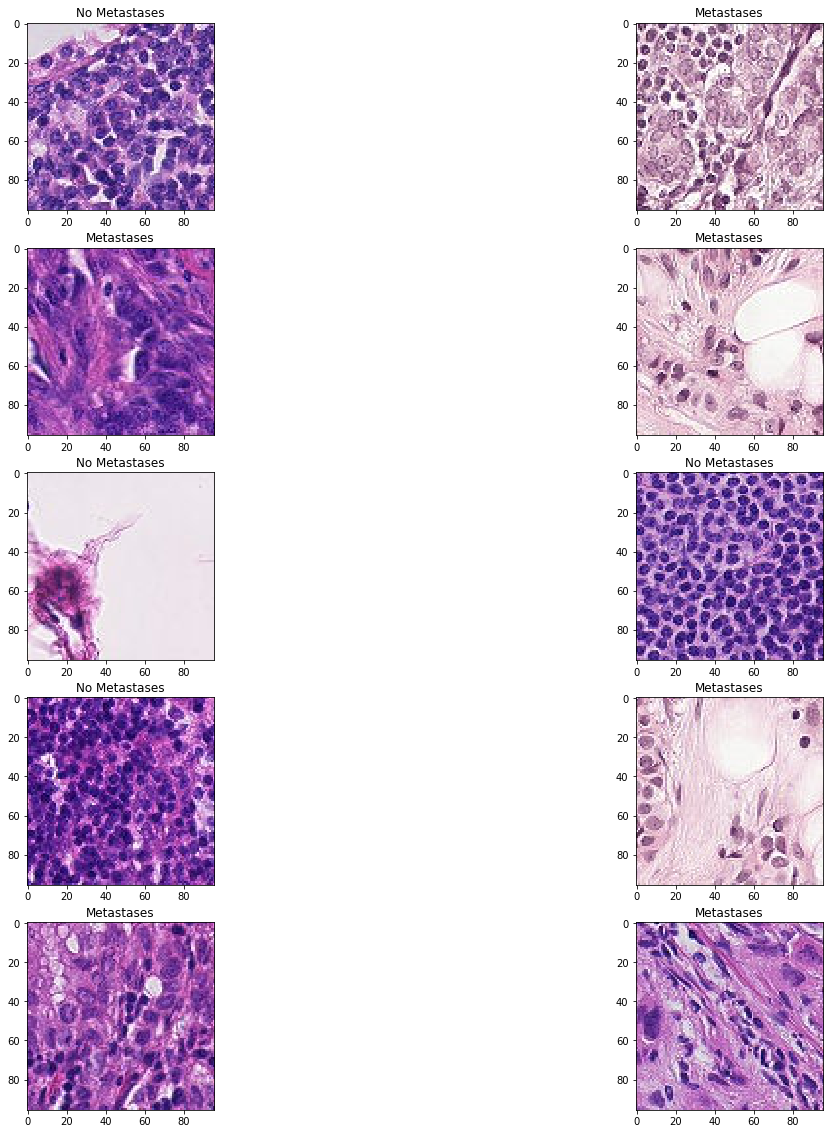

In [14]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
for i, (img, label) in enumerate(zip(sample_img, sample_y)):
    ax[i//2,i%2].title.set_text("Metastases" if label == 1 else "No Metastases")
    ax[i//2,i%2].imshow(img)

### Preprocessing

As before, we need to normalize the color channels before feeding the images to our model.  In contrast to our prior lesson however, we are going to use the color channel statistics from ImageNet.  This is because the pretrained model that we are going to use was trained on ImageNet and expects inputs from that distribution.  Keras includes preprocessing, utilities with its pretrained models to help facilitate this process.

In [15]:
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input
color_mean=[0.485, 0.456, 0.406]
color_std=[0.229, 0.224, 0.225]

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,

    width_shift_range=4,  # randomly shift images horizontally
    height_shift_range=4,  # randomly shift images vertically 
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True
) 

eval_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

## Build Model

### Transfer Learning

In contrast to yesterday where we trained the entire model from scratch, we are going to re-use the body from a pretrained model.  The model that we are going to use was trained on ImageNet, a set of 14 million labelled images.  Empirically, we hav seen that a sophisticated model trained on such a large dataset to convergence is able to extract very useful features across a number of domains, including medical imaging.

Keras makes a number of pretrained models available through its "applications" API which you can learn more about [here](https://keras.io/applications/).  In Code Lab 2, we are going to use ResNet50v2 which offers a good comprimise between size and accuracy.

In [17]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.applications import ResNet50

#### ResNet50

Before we get started building our model, let's inspect the architecture of the base model.  This will take a while as we need to download the ~100MB of pretrained weights for the model.

In [18]:
example_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(96,96,3), pooling=None)

/home/onepanel/.conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Let's view the summary of the model using the Keras utility.  Immediately, we can tell that this model is significantly larger than the model we trained yesterday.  Note the repitition of blocks and the pattern of reducing spatial dimensionality while increasing filter count as we go higher in the model.

In [19]:
example_resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Now let's build our real model.

In [22]:
def make_models(dropout_rate=0.2):
    full_model = ResNet50(weights='imagenet', input_shape=(96,96,3),include_top=False)
    x = GlobalAveragePooling2D()(full_model.output)
    x = Dense(2048)(x)
    x = Dropout(dropout_rate)(x)
    prediction = Dense(1,activation='sigmoid')(x)

    
    pcammodel = Model(inputs=full_model.input, outputs=prediction)
    return pcammodel, full_model


def freeze_base(feature_map):
    for layer in feature_map.layers:
        layer.trainable = False

  
def unfreeze_base(feature_map,top_n=None):
    layers = feature_map.layers
    
    if top_n is not None and top_n < len(layers):
        layers = layers[-top_n:]
    for layer in layers:
        print("Unfreezing %s" % layer.name)
        layer.trainable = True

In [23]:
model, feature_map = make_models()

At first we will train only the parameters of our head.

In [24]:
freeze_base(feature_map)

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Training

As usual, we need to set up both our loss function and our optimizer.  We will continue to use  Binary Cross Entropy and Adam respectively.

In [26]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE, clipvalue=1.)

In [27]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics=['acc']

Let's also set up some callbacks to help us while we train our model.  Keras supports a large number of useful functions.  I recommend you refence the [documentation](https://keras.io/callbacks/) for more information.

In [28]:
save_best = tf.keras.callbacks.ModelCheckpoint('best_model',save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3,min_lr=LEARNING_RATE/1000)
tb_cb = tf.keras.callbacks.TensorBoard(log_dir='/onepanel/output/model3')
hist = tf.keras.callbacks.History()
callbacks = [save_best, early_stopping, reduce_lr, tb_cb, hist]

In [29]:
model.compile(optimizer,
              loss=loss_fn,
              metrics=metrics)

In [30]:
EPOCHS=5
BATCH_SIZE=32
# FLOW_DIR = 'flow'
# if not os.path.exists(FLOW_DIR):
#   os.mkdir(FLOW_DIR)

In [31]:
history = model.fit_generator(train_generator.flow(datasets['train']['x'],
                                 datasets['train']['y'],
                                 batch_size=BATCH_SIZE),
                              steps_per_epoch=len(datasets['train']['x']) / BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              validation_data=eval_generator.flow(datasets['valid']['x'],
                                 datasets['valid']['y'],
                                 batch_size=BATCH_SIZE),
                              validation_steps=len(datasets['valid']['x']) / BATCH_SIZE,
                              max_queue_size=4)

Epoch 1/5
3125/3125 [==============================] - 239s 76ms/step - loss: 0.4826 - acc: 0.8124 - val_loss: 0.9577 - val_acc: 0.6262
Epoch 2/5
3125/3125 [==============================] - 216s 69ms/step - loss: 0.4541 - acc: 0.8167 - val_loss: 1.1976 - val_acc: 0.6457
Epoch 3/5
3125/3125 [==============================] - 216s 69ms/step - loss: 0.4736 - acc: 0.8155 - val_loss: 1.5665 - val_acc: 0.6092
Epoch 4/5
3125/3125 [==============================] - 216s 69ms/step - loss: 0.4796 - acc: 0.8168 - val_loss: 1.6571 - val_acc: 0.6142
Epoch 5/5
3125/3125 [==============================] - 217s 69ms/step - loss: 0.3510 - acc: 0.8493 - val_loss: 1.0206 - val_acc: 0.6093


## Evaluate

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


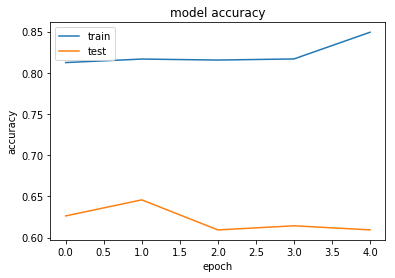

In [32]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

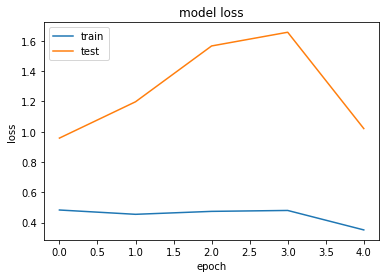

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
test_predictions = model.predict(datasets['test']['x'])

In [35]:
THRESHOLD = 0.4
test_classes = np.where(test_predictions > THRESHOLD, 1, 0)

In [36]:
from sklearn.metrics import classification_report
display(classification_report(datasets['test']['y'],test_classes, output_dict=True))

{'0': {'precision': 0.5638630636892866,
  'recall': 0.7918369837105729,
  'f1-score': 0.658682026948159,
  'support': 16391},
 '1': {'precision': 0.650051282051282,
  'recall': 0.38700616718568726,
  'f1-score': 0.48516859953305014,
  'support': 16377},
 'micro avg': {'precision': 0.589508056640625,
  'recall': 0.589508056640625,
  'f1-score': 0.589508056640625,
  'support': 32768},
 'macro avg': {'precision': 0.6069571728702843,
  'recall': 0.58942157544813,
  'f1-score': 0.5719253132406046,
  'support': 32768},
 'weighted avg': {'precision': 0.6069387610804731,
  'recall': 0.589508056640625,
  'f1-score': 0.5719623797076427,
  'support': 32768}}

In [42]:
import sklearn
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function 
    s and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    FROM: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[sklearn.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


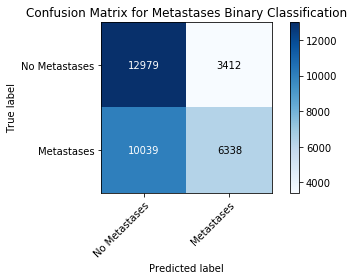

In [43]:
plot_confusion_matrix(datasets['test']['y'],
                      test_classes,['No Metastases','Metastases'],
                      title='Confusion Matrix for Metastases Binary Classification')

### Inspect Predictions

In [44]:
wrong_mask = (datasets['test']['y'] != test_classes.reshape(-1)).reshape(-1)
wrong_labels = datasets['test']['y'][wrong_mask]
wrong_preds = test_classes[wrong_mask]
count_wrong = np.sum(wrong_mask)
wrong_images = np.zeros((count_wrong,96,96,3),dtype=np.uint8)
wrong_cursor = 0
for i, wrong in enumerate(wrong_mask):
    if wrong:
        wrong_images[wrong_cursor] = np.array(datasets['test']['x'][i])
        wrong_cursor +=1

In [45]:
wrong_images.dtype

dtype('uint8')

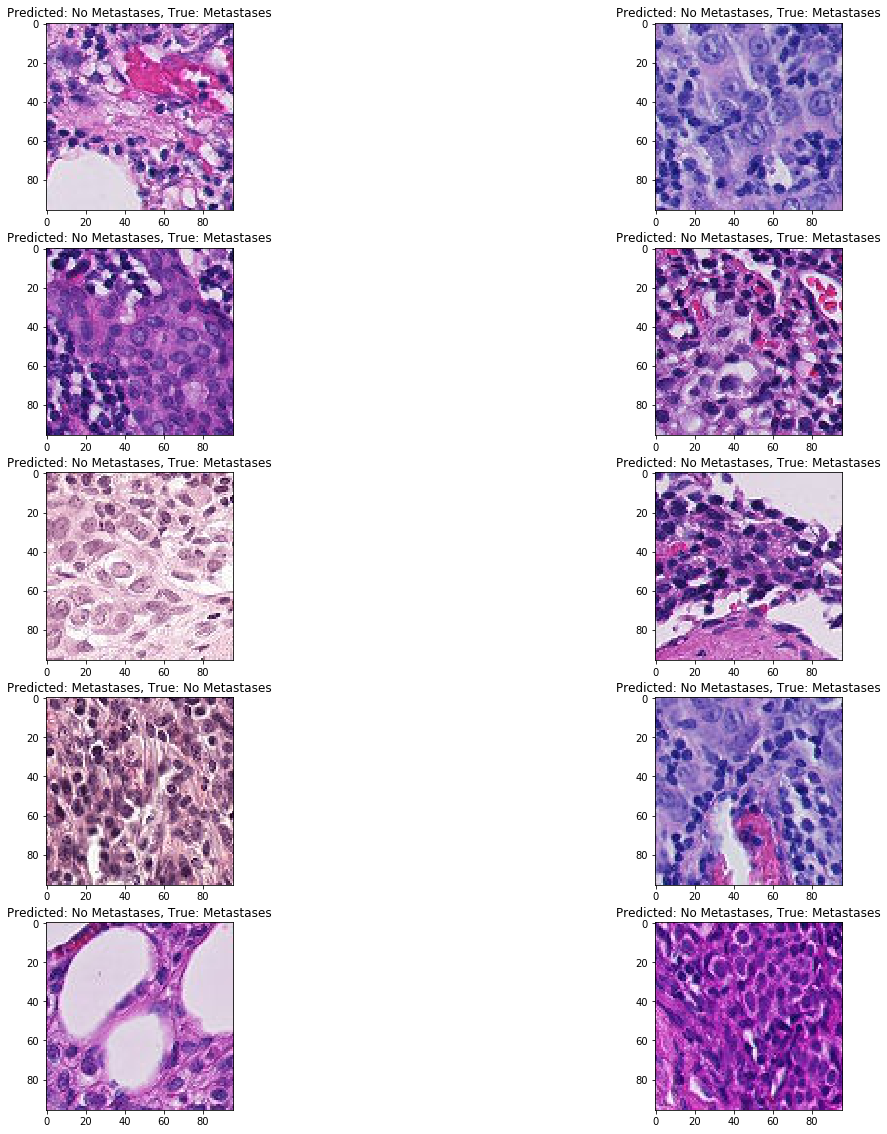

In [46]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
for i, (label, pred, original_image) in enumerate(zip(wrong_labels[:10],wrong_preds[:10],wrong_images[:10])):
    label_txt = 'No Metastases' if label == 0 else 'Metastases'
    pred_txt = 'No Metastases' if pred == 0 else 'Metastases'
#     original_image = (image_std * channel_std +  channel_mean).astype(np.uint8)
    ax[i//2,i%2].title.set_text('Predicted: %s, True: %s' % (pred_txt, label_txt))
    ax[i//2,i%2].imshow(original_image)